# 1. Data Understanding and Cleaning

In [13]:
# Step 1: Import Libraries,Load Dataset and Select Required Columns
import pandas as pd
import numpy as np

df = pd.read_csv("swiggy.csv")
required_columns = ['name', 'city', 'cuisine', 'rating', 'rating_count', 'cost']
df = df[required_columns]

# Split 'city' into 'sub_city' and 'main_city'
city_split = df['city'].str.split(',', n=1, expand=True)
df['sub_city'] = city_split[0].str.strip()
df['main_city'] = city_split[1].str.strip() if city_split.shape[1] > 1 else None

# Drop original 'city' column
df = df.drop(columns=['city'])

#Viewing Columns
print("Initial Columns:", df.columns.tolist())

Initial Columns: ['name', 'cuisine', 'rating', 'rating_count', 'cost', 'sub_city', 'main_city']


In [14]:
# Step 2: Data Cleaning and Type Conversion 

# Rating
df['rating'] = pd.to_numeric(df['rating'].replace('--', pd.NA), errors='coerce')

# Rating Count
df['rating_count'] = df['rating_count'].str.replace(r'[^0-9]', '', regex=True)
df['rating_count'] = pd.to_numeric(df['rating_count'], errors='coerce').astype('Int64')

# Cost
df['cost'] = df['cost'].str.replace(r'[^\d]', '', regex=True)
df['cost'] = pd.to_numeric(df['cost'], errors='coerce').astype('Int64')

print("Data types after conversion:\n", df.dtypes)

Data types after conversion:
 name             object
cuisine          object
rating          float64
rating_count      Int64
cost              Int64
sub_city         object
main_city        object
dtype: object


In [15]:
# Step 3: Drop Duplicates and Handle Missing 

print("Duplicates before:", df.duplicated().sum())
df = df.drop_duplicates()
print("Duplicates after:", df.duplicated().sum())

# Handle missing
df = df.dropna(subset=['name', 'sub_city', 'main_city'])
df['cuisine'] = df['cuisine'].fillna('Unknown')
df['rating'] = df['rating'].fillna(df['rating'].median())
df['rating_count'] = df['rating_count'].fillna(0).astype(int)
df['cost'] = df['cost'].fillna(df['cost'].median()).astype(int)

print("Missing values after cleaning:\n", df.isna().sum())
df.to_csv("cleaned_data.csv", index=False)

Duplicates before: 35
Duplicates after: 0
Missing values after cleaning:
 name            0
cuisine         0
rating          0
rating_count    0
cost            0
sub_city        0
main_city       0
dtype: int64


# 2. Data Preprocessing

In [ ]:
# Step 4: Encoding
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MultiLabelBinarizer
import pickle

df = pd.read_csv("cleaned_data.csv")

# Label Encode restaurant name
le = LabelEncoder()
df['name_encoded'] = le.fit_transform(df['name'])
with open("label_encoder_name.pkl", "wb") as f:
    pickle.dump(le, f)

# One-Hot Encode sub_city and main_city
city_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
city_encoded = pd.DataFrame(
    city_encoder.fit_transform(df[['sub_city', 'main_city']]),
    columns=city_encoder.get_feature_names_out(['sub_city', 'main_city'])
)

with open("city_encoder.pkl", "wb") as f:
    pickle.dump(city_encoder, f)

# Split 'cuisine' into multiple labels
df['cuisine'] = df['cuisine'].str.split(',\s*')
mlb = MultiLabelBinarizer()
cuisine_encoded = pd.DataFrame(mlb.fit_transform(df['cuisine']), columns=mlb.classes_)

with open("cuisine_encoder.pkl", "wb") as f:
    pickle.dump(mlb, f)

# Final dataframe
numerical = df[['rating', 'rating_count', 'cost', 'name_encoded']].reset_index(drop=True)
final_df = pd.concat([numerical, city_encoded, cuisine_encoded], axis=1)
print("All features numeric:", final_df.dtypes.apply(pd.api.types.is_numeric_dtype).all())

final_df.to_csv("final_encoded_data.csv", index=False)

<>:24: SyntaxWarning: invalid escape sequence '\s'
<>:24: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Satya\AppData\Local\Temp\ipykernel_4652\829157849.py:24: SyntaxWarning: invalid escape sequence '\s'
  df['cuisine'] = df['cuisine'].str.split(',\s*')


All features numeric: True


# 3. Recommendation Methodology

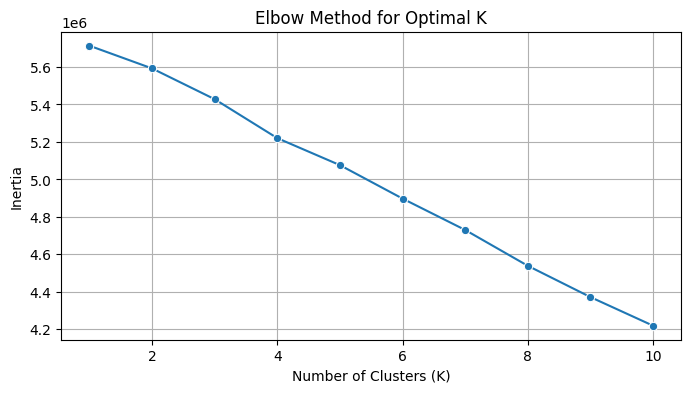

In [5]:
# Step 5: Clustering 
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

df_encoded = pd.read_csv("final_encoded_data.csv")

# Scaling
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_encoded)

# PCA to reduce dimensions
pca = PCA(n_components=30, random_state=42)
reduced_data = pca.fit_transform(scaled_data)

# Elbow method
inertia = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(reduced_data)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
sns.lineplot(x=range(1, 11), y=inertia, marker='o')
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method for Optimal K")
plt.grid(True)
plt.show()

In [18]:
# Step 6: Apply KMeans with Optimal K 
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans.fit_predict(reduced_data)
df_encoded['cluster'] = clusters

# Save
df_encoded.to_csv("final_encoded_data.csv", index=False)
print("Cluster counts:\n", df_encoded['cluster'].value_counts())

Cluster counts:
 cluster
3    88382
1    56787
2     2416
0      860
Name: count, dtype: int64


In [19]:
# Step 7: Map Cluster Labels to Original Data 
original_df = pd.read_csv("cleaned_data.csv")
encoded_df = pd.read_csv("final_encoded_data.csv")

# Align indices
original_df = original_df.reset_index(drop=True)
encoded_df = encoded_df.reset_index(drop=True)

# Assign cluster
original_df['cluster'] = encoded_df['cluster']
original_df.to_csv("clustered_cleaned_data.csv", index=False)
print("Cluster labels mapped and saved to 'clustered_cleaned_data.csv'")

Cluster labels mapped and saved to 'clustered_cleaned_data.csv'
